In [1]:
import os, sys
HOME_DIR = os.path.join(os.getcwd(), '..')
sys.path.append(HOME_DIR)
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rdkit
from rdkit import Chem
import torch
from torch_geometric.loader import DataLoader
from substrate_metric_learning.networks import Net
from substrate_metric_learning.utils import *
from substrate_metric_learning.features import smiles_to_graph_substrate, smiles_to_graph
from rdkit.Chem import Draw
from tqdm.notebook import tqdm
import random

from sklearn.decomposition import PCA
from sklearn import manifold
from umap import UMAP
import sklearn

import matplotlib

def save_fig(ax,file_path):
    matplotlib.rcParams['pdf.fonttype'] = 42
    matplotlib.rcParams['ps.fonttype'] = 42
    plt = ax.get_figure()
    plt.savefig(file_path, transparent=True)
    return

/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/whgao/miniconda3/envs/molfit/lib/python3.8/site-packages/umap/dist

In [2]:
config_path = os.path.join(HOME_DIR, "configs/hparams_default.yaml")
config = Objdict(yaml.safe_load(open(config_path)))
input_dim = 133
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1.172
model_pretrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_pretrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_56_sum_r2_1.538.pth"))
model_untrained = Net(input_dim, config.hidden_channels, 1, config.num_layers, config.pool).to(device)
model_untrained.load_state_dict(torch.load("/home/whgao/substrate_metric_learning/results/default/gin_epoch_0.pth"))

@torch.no_grad()
def get_embedding_from_smi(smi_list, c_index_list, model, device):
    assert len(smi_list) == len(c_index_list)
    assert model.pool_method == 'c'
    train_dataset = [smiles_to_graph_substrate(smiles=smi_list[i], s=0, y=0, atm_idx=[c_index_list[i]]) for i in range(len(smi_list))]
    loader = DataLoader(train_dataset, 128, shuffle=False)
    model.eval()
    embeddings = []
    for data in loader:
        data = data.to(device)
        _, emb = model(data.x, data.edge_index, data.batch, data.atm_idx)
        embeddings.append(emb.cpu().detach().numpy())
    return np.concatenate(embeddings, axis=0)

# Data

In [3]:
data_temp = pd.read_csv(os.path.join(HOME_DIR, "data/arylhalide_database_w_idx_min5.csv"))
data_temp.ScopeID.unique().shape

(6919,)

In [4]:
random.seed(0)
np.random.seed(0)
data_full = pd.read_csv(os.path.join(HOME_DIR, "data/arylhalide_database_w_idx.csv"))
halides = [Chem.MolFromSmiles(data_full.Arylhalide[i]).GetAtoms()[int(data_full.halide_index[i])].GetSymbol() for i in range(len(data_full))]
data_full['Halide'] = halides

data_random = data_full.sample(frac=0.05, random_state=42).reset_index(drop=True)
train_dataset = [smiles_to_graph_substrate(smiles=data_random['Arylhalide'][ind], 
                                        s=data_random['ScopeID'][ind], 
                                        y=data_random['Yield'][ind]/100, 
                                            atm_idx=[data_random['aroma_c_index'][ind]]) for ind in range(len(data_random))]
   
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained_random = get_embedding(model_pretrained, loader, device)
embeddings_untrained_random = get_embedding(model_untrained, loader, device)

In [5]:
data_selected = pd.read_csv(os.path.join(HOME_DIR, "data/ah_selected_autoqchem.csv"))

train_dataset = [smiles_to_graph(smiles=data_selected['smiles'][ind], 
                                        y=data_selected['global_charge'][ind], 
                                            atm_idx=[data_selected['c_index'][ind]]) for ind in range(len(data_selected))]
loader = DataLoader(train_dataset, 128, shuffle=False)

embeddings_pretrained_selected = get_embedding(model_pretrained, loader, device)
embeddings_untrained_selected = get_embedding(model_untrained, loader, device)

In [6]:
embeddings_pretrained = np.concatenate([embeddings_pretrained_random, embeddings_pretrained_selected], axis=0)
embeddings_untrained = np.concatenate([embeddings_untrained_random, embeddings_untrained_selected], axis=0)

data = pd.concat([data_random, data_selected], axis=0).reset_index(drop=True)

In [7]:
data_random.Arylhalide.unique().shape[0], data_selected.smiles.unique().shape[0]

(4309, 762)

{'Cl': 0, 'Br': 1, 'I': 2, 'F': 3}


/home/whgao/tmp/ipykernel_383174/2717651646.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


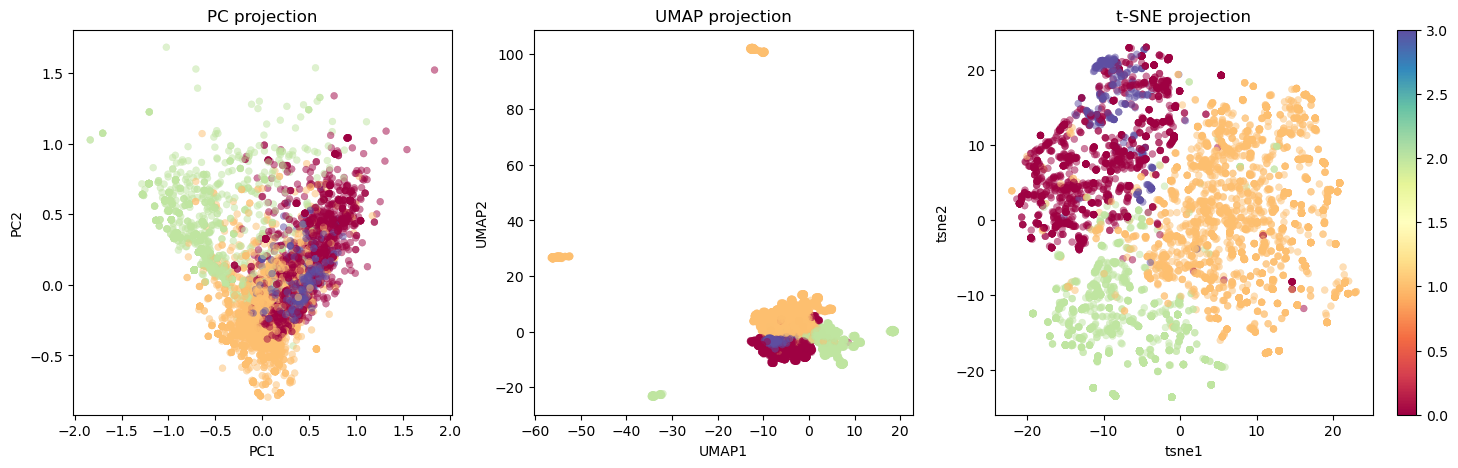

In [20]:
random.seed(0)
np.random.seed(0)

dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_pretrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_pretrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=64,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_pretrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_pretrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in data.Halide])

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

# ax[1].set_xlim((-5, 20))
# ax[1].set_ylim((-15, 15))

plt.show()

{'Cl': 0, 'Br': 1, 'I': 2, 'F': 3}


/home/whgao/tmp/ipykernel_383174/2089785131.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


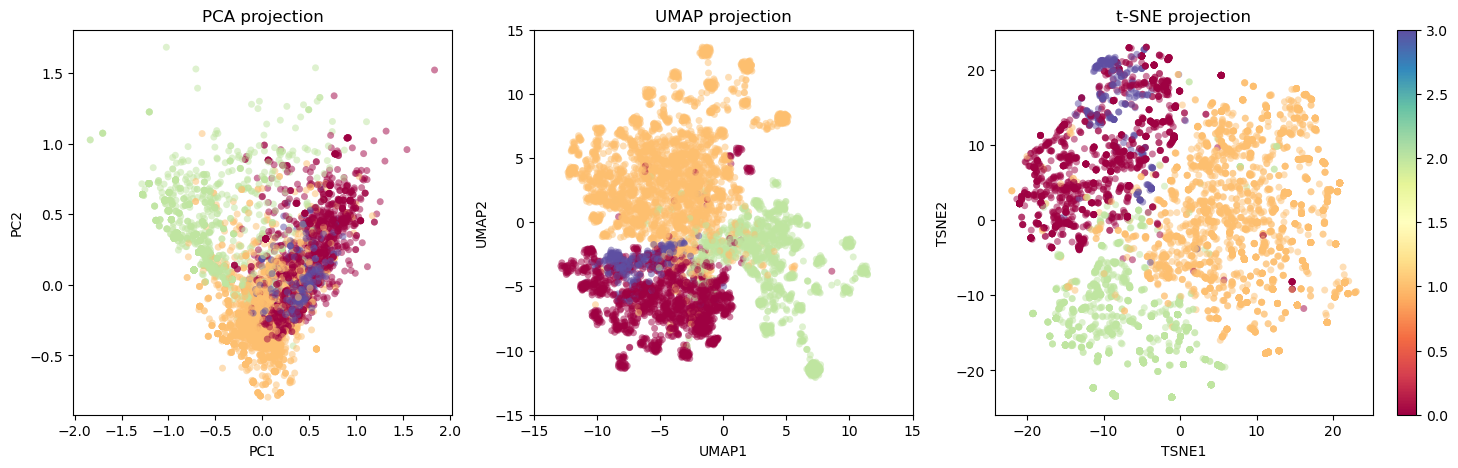

In [22]:
f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['TSNE1', 'TSNE2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0., c=c_list, cmap='Spectral', edgecolor=None, ax=ax[0]).set_title("PCA projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0., c=c_list, cmap='Spectral', edgecolor=None, ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='TSNE1', y='TSNE2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0., c=c_list, cmap='Spectral', edgecolor=None, ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

ax[1].set_xlim((-15, 15))
ax[1].set_ylim((-15, 15))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# plt.show()
plt.savefig("embeddings_pretrained.pdf", transparent=True)

{'Cl': 0, 'Br': 1, 'I': 2, 'F': 3}


/home/whgao/tmp/ipykernel_383174/1377243740.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


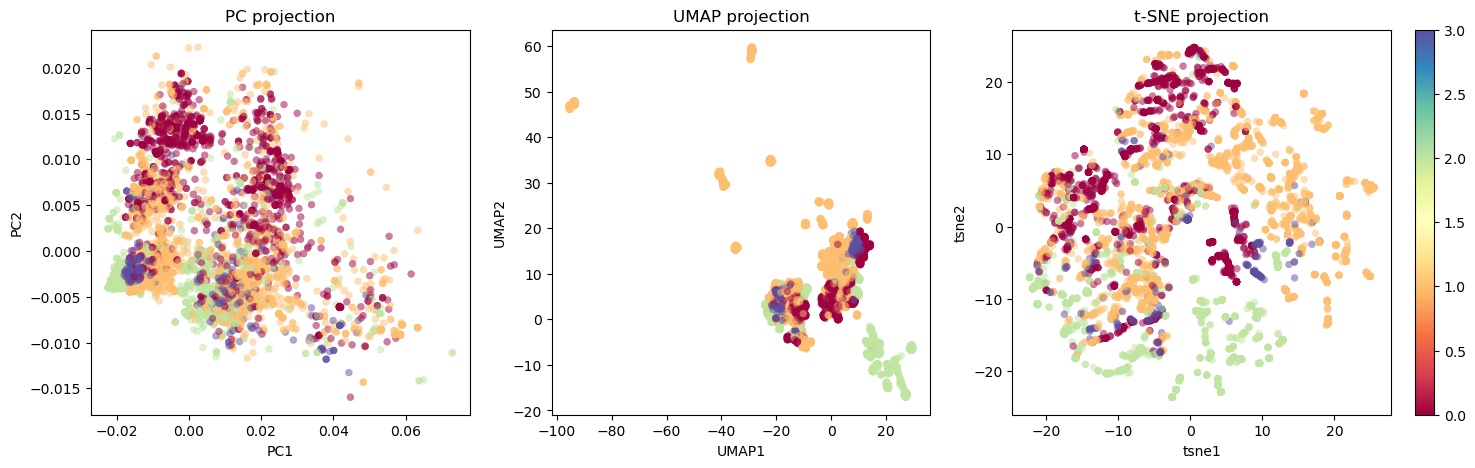

In [17]:
random.seed(0)
np.random.seed(0)

dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embeddings_untrained.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_untrained), index=data.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=64,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embeddings_untrained), index=data.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embeddings_untrained), index=data.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in data.Halide])

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

# ax[1].set_xlim((-5, 20))
# ax[1].set_ylim((-15, 15))

plt.show()

{'Cl': 0, 'Br': 1, 'I': 2, 'F': 3}


/home/whgao/tmp/ipykernel_383174/1866259575.py:15: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


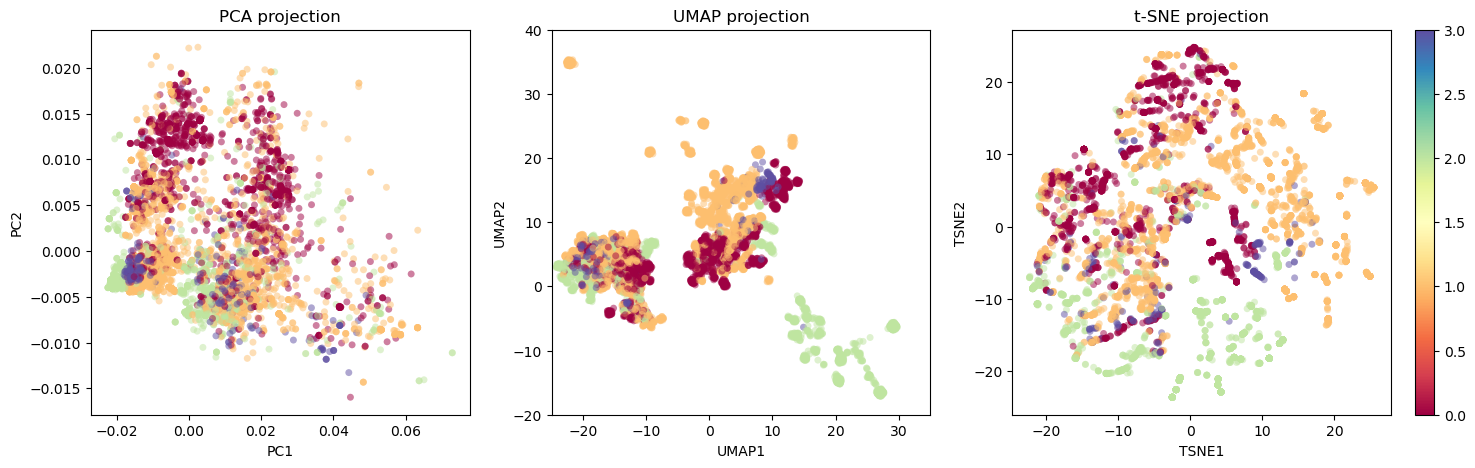

In [19]:
f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['TSNE1', 'TSNE2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0., c=c_list, cmap='Spectral', edgecolor=None, ax=ax[0]).set_title("PCA projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0., c=c_list, cmap='Spectral', edgecolor=None, ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='TSNE1', y='TSNE2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0., c=c_list, cmap='Spectral', edgecolor=None, ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

ax[1].set_xlim((-25, 35))
ax[1].set_ylim((-20, 40))

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# plt.show()
plt.savefig("embeddings_untrained.pdf", transparent=True)

In [12]:
temp_list = []
for smi in data_random['Arylhalide'].to_list() + data_selected['smiles'].to_list():
    mol = Chem.MolFromSmiles(smi)
    [a.SetAtomMapNum(0) for a in mol.GetAtoms()]
    temp_list.append(Chem.MolToSmiles(mol, canonical=True))
    
df_temp = pd.DataFrame({
    'smiles': temp_list,
    'halogen': data['Halide'].to_list(),
    'dim1': dfs['tsne2']['tsne1'].to_list(),
    'dim2': dfs['tsne2']['tsne2'].to_list(),
})

df_temp = df_temp.drop_duplicates(subset=['smiles', 'halogen'], keep='first')
df_temp.to_csv('temp.csv', index=False)

In [9]:
df_temp = pd.read_csv('temp.csv')
len(df_temp)

3684

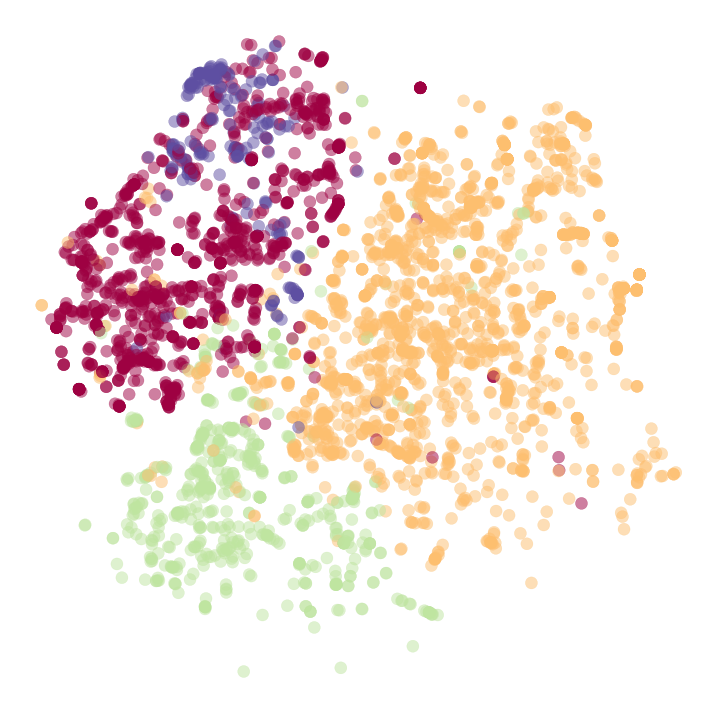

In [10]:
random.seed(0)
np.random.seed(0)

scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in data.Halide])

# dim = 2
# dfs={}
# # UMAP section
# n_neighbors = int(np.sqrt(embeddings_pretrained.shape[1]))

# key = f"umap{dim}"
# dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_pretrained), index=data.index)
# scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in df_temp.halogen])

# dfs['umap2'].columns = ['UMAP1', 'UMAP2']

fig, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(x='dim1', y='dim2', data=df_temp, s=75, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax)
# Remove axes
plt.axis('off')

# Set background color to transparent
plt.gca().set_facecolor('none')

# ax.set_xlim((-13, 17))
# ax.set_ylim((-15, 15))

plt.show()
# save_fig(ax, 'tsne_projection_all.pdf')
# plt.savefig('tsne_projection_all.png', dpi=1000, bbox_inches='tight', transparent=True)

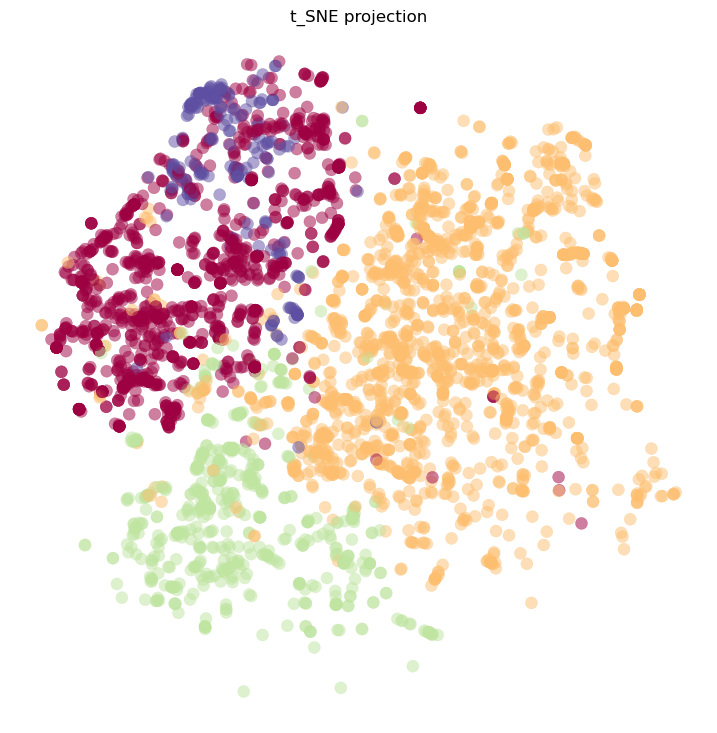

In [15]:
random.seed(0)
np.random.seed(0)

# dim = 2
# dfs={}
# # UMAP section
# n_neighbors = int(np.sqrt(embeddings_pretrained.shape[1]))

# key = f"umap{dim}"
# dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embeddings_pretrained), index=data.index)
# scope_id2ind = {id: i for i, id in enumerate(data.Halide.unique())}
c_list = np.array([scope_id2ind[id] for id in df_temp.halogen])

# dfs['umap2'].columns = ['UMAP1', 'UMAP2']

fig, ax = plt.subplots(figsize=(9, 9))
sns.scatterplot(x='dim1', y='dim2', data=df_temp, s=75, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax).set_title("t_SNE projection")
# Remove axes
plt.axis('off')

# Set background color to transparent
plt.gca().set_facecolor('none')

# ax.set_xlim((-13, 17))
# ax.set_ylim((-15, 15))

plt.show()
# plt.savefig('tsne_projection_all.png', dpi=1000, bbox_inches='tight', transparent=True)

/home/whgao/tmp/ipykernel_364206/1791261422.py:42: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax.figure.colorbar(sm)


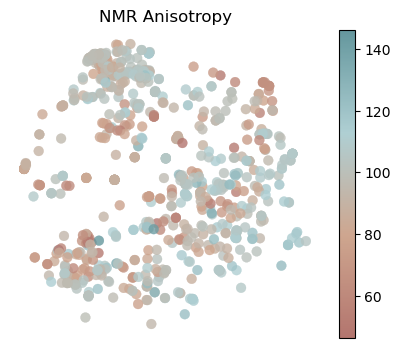

In [45]:
fig, ax = plt.subplots(figsize=(5, 4))

label_name = 'local_NMR_anisotropy'

hex_colors = [
    'B3756E', 'CEA68F', 'AFCFD3', '64979D'
]


# Convert hex color values to RGB values
rgb_colors = [tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4)) for hex_color in hex_colors]

# Normalize the RGB values to the range 0-1 (required by matplotlib)
rgb_normalized = [(r/255, g/255, b/255) for r, g, b in rgb_colors]

# Now we'll create a colormap from the list of normalized RGB values.
from matplotlib.colors import LinearSegmentedColormap

custom_colormap = LinearSegmentedColormap.from_list('custom_cmap', rgb_normalized)




c_list_temp = data[data['Yield'].isna()][label_name].to_numpy()
title = label_name
title = "NMR Anisotropy"

sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'][data['Yield'].isna()], s=50, alpha=0.8, linewidth=0.25, c=c_list_temp, cmap=custom_colormap, edgecolor='face', ax=ax).set_title(title)
# Remove axes
plt.axis('off')



# Set background color to transparent
plt.gca().set_facecolor('none')

norm = plt.Normalize(c_list_temp.min(), c_list_temp.max())
sm = plt.cm.ScalarMappable(cmap=custom_colormap, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.figure.colorbar(sm)

# ax.set_xlim((-13, 17))
# ax.set_ylim((-15, 15))

# plt.show()
save_fig(ax, 'tsne_projection_' + label_name + '.pdf')
# plt.savefig('tsne_projection_NMR_anisotropy.png', dpi=500, bbox_inches='tight', transparent=True)

In [24]:
data.columns

Index(['RxnSMILES', 'Arylhalide', 'Canonical', 'RxnID', 'Yield', 'ScopeID',
       'ScopeSize', 'aroma_c_index', 'halide_index', 'Halide', 'smiles',
       'c_index', 'x_index', 'global_number_of_atoms', 'global_charge',
       'global_multiplicity', 'global_dipole', 'global_molar_mass',
       'global_molar_volume', 'global_electronic_spatial_extent',
       'global_E_scf', 'global_zero_point_correction',
       'global_E_thermal_correction', 'global_H_thermal_correction',
       'global_G_thermal_correction', 'global_E_zpe', 'global_E', 'global_H',
       'global_G', 'global_stoichiometry', 'global_converged',
       'global_homo_energy', 'global_lumo_energy', 'global_electronegativity',
       'global_hardness', 'global_ES_root_dipole',
       'global_ES_root_molar_volume',
       'global_ES_root_electronic_spatial_extent', 'local_X', 'local_Y',
       'local_Z', 'local_VBur', 'local_Mulliken_charge', 'local_APT_charge',
       'local_NPA_charge', 'local_NPA_core', 'local_NPA_valenc

# Buyable

In [3]:
data_buyable = pd.read_csv("../data/buyable_aryl_bromides.csv")
data_buyable = data_buyable[data_buyable['informer'] == False]
data_buyable

,smiles,c_index,x_index,in_doyle,informer
0,BrC1=CC=C(C=O)C=C1,1,0,False,False
1,BrC1=CC=CC=C1,1,0,False,False
2,CC(=O)C1=CC=C(Br)C=C1,6,7,False,False
3,COC1=CC=C(Br)C=C1,5,6,False,False
4,CC1=CC=C(Br)C=C1,4,5,False,False
...,...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,5,False,False
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,1,0,False,False
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,8,9,False,False
2679,CC1=CC(Br)=CC(=C1)C(F)F,3,4,False,False


In [4]:
embedding_buyable = get_embedding_from_smi(
    data_buyable.smiles.to_list(),
    data_buyable.c_index.to_list(),
    model_pretrained,
    device
)
embedding_buyable

array([[0.06432461, 0.        , 0.23764059, ..., 0.02704882, 0.05415156,
        0.        ],
       [0.05916466, 0.        , 0.23454586, ..., 0.        , 0.13848276,
        0.        ],
       [0.12707895, 0.        , 0.1815683 , ..., 0.0158989 , 0.05187145,
        0.        ],
       ...,
       [0.        , 0.20342754, 0.04901795, ..., 0.23586304, 0.09463511,
        0.        ],
       [0.        , 0.        , 0.20477435, ..., 0.        , 0.00315781,
        0.        ],
       [0.        , 0.        , 0.0209021 , ..., 0.        , 0.1609698 ,
        0.        ]], dtype=float32)

{False: 0, True: 1}


/home/whgao/tmp/ipykernel_2302389/2349537092.py:46: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


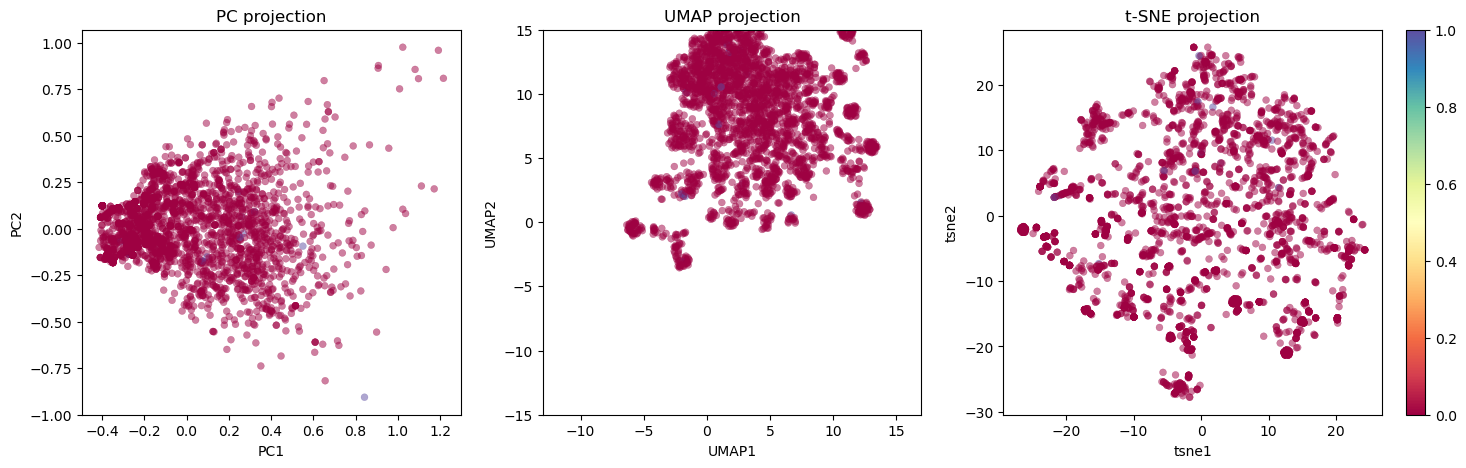

In [9]:
random.seed(0)
np.random.seed(0)

dim = 2
dfs={}
# UMAP section
n_neighbors = int(np.sqrt(embedding_buyable.shape[1]))

key = f"umap{dim}"
dfs[key] = pd.DataFrame(UMAP(n_components=dim, n_neighbors=256, min_dist=0.99, metric='cosine', random_state=0).fit_transform(embedding_buyable), index=data_buyable.index)

# t-SNE section
key = f"tsne{dim}"
t_sne = manifold.TSNE(
    n_components=dim,
    perplexity=64,
    init="random",
    n_iter=350,
    random_state=0,
)
dfs[key] = pd.DataFrame(t_sne.fit_transform(embedding_buyable), index=data_buyable.index)

# PCA section
pc = pd.DataFrame(PCA(n_components=None).fit_transform(embedding_buyable), index=data_buyable.index)

key = f"pc{dim}"
dfs[key] = pc.iloc[:, :dim]

scope_id2ind = {id: i for i, id in enumerate(data_buyable.in_doyle.unique())}
c_list = np.array([scope_id2ind[id] for id in data_buyable.in_doyle])

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.5, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
print(scope_id2ind)
ax[2].figure.colorbar(sm)

ax[1].set_xlim((-13, 17))
ax[1].set_ylim((-15, 15))

plt.show()

In [5]:
from sklearn.cluster import DBSCAN, KMeans

def snr_distance(ri, rj):
    return np.var(ri - rj) / np.var(ri)

clustering = KMeans(n_clusters=15, random_state=0).fit(embedding_buyable[:100])
clustering.labels_

array([10, 14, 10, 14, 14,  4, 10,  3,  5, 12, 14, 12,  7, 12, 10, 14, 12,
       14,  4, 10, 12, 10, 12,  3, 10,  7,  5, 14,  0, 14, 14,  0,  0, 14,
        3, 12,  8,  2,  1,  7,  3, 13, 12,  0,  1,  1,  7, 14,  5, 12,  4,
        1, 12,  0, 10,  7,  6, 10, 14, 12, 12,  5, 12, 10,  3, 12,  7, 10,
        5, 14,  3,  5,  3,  4,  4,  0,  1,  5,  4, 10, 12, 12, 12, 14,  9,
        1, 10, 12,  1,  7,  7,  1,  0, 10, 11,  5, 14,  7,  1,  1],
      dtype=int32)

In [6]:
clustering = KMeans(n_clusters=15, random_state=0).fit(embedding_buyable)
clustering.labels_

array([ 6,  8,  6, ...,  2,  0, 14], dtype=int32)

In [7]:
data_buyable['cluster'] = clustering.labels_

/home/whgao/tmp/ipykernel_2302389/1579115525.py:19: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  ax[2].figure.colorbar(sm)


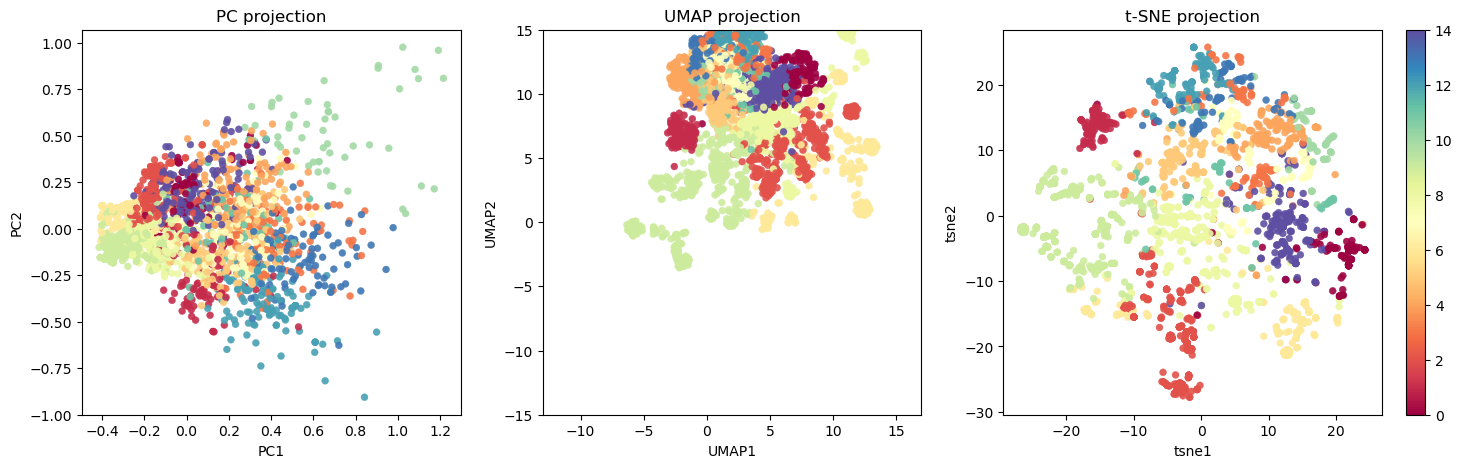

In [10]:
c_list = clustering.labels_
# for i in range(len(data_buyable)):
#     if data_buyable.in_doyle[i] == True:
#         c_list[i] = 15

f, ax = plt.subplots(1, 3, figsize=(18, 5), width_ratios=[4, 4, 5]) #, dpi=200)
dfs['pc2'].columns = ['PC1', 'PC2'] 
dfs['umap2'].columns = ['UMAP1', 'UMAP2']
dfs['tsne2'].columns = ['tsne1', 'tsne2']
_ = sns.scatterplot(x='PC1', y='PC2', data=dfs['pc2'], s=25, alpha=0.9, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[0]).set_title("PC projection") 
_ = sns.scatterplot(x='UMAP1', y='UMAP2', data=dfs['umap2'], s=25, alpha=0.9, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[1]).set_title("UMAP projection")
_ = sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=25, alpha=0.9, linewidth=0.25, c=c_list, cmap='Spectral', edgecolor='face', ax=ax[2]).set_title("t-SNE projection")

norm = plt.Normalize(c_list.min(), c_list.max())
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax[2].figure.colorbar(sm)

ax[1].set_xlim((-13, 17))
ax[1].set_ylim((-15, 15))

plt.show()

In [21]:
  
df_temp = pd.DataFrame({
    'smiles': data_buyable.smiles.to_list(),
    'cluster': c_list,
    'dim1': dfs['tsne2']['tsne1'].to_list(),
    'dim2': dfs['tsne2']['tsne2'].to_list(),
})

df_temp = df_temp.drop_duplicates(subset=['smiles'], keep='first')
df_temp.to_csv('temp_buyable.csv', index=False)

In [3]:
df_temp = pd.read_csv('temp_buyable.csv')
df_temp

,smiles,cluster,dim1,dim2
0,BrC1=CC=C(C=O)C=C1,6,17.931244,-16.849379
1,BrC1=CC=CC=C1,8,11.323627,-11.400373
2,CC(=O)C1=CC=C(Br)C=C1,6,14.835684,-18.505522
3,COC1=CC=C(Br)C=C1,8,7.367188,-13.063218
4,CC1=CC=C(Br)C=C1,8,8.093181,-13.837367
...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,3.419410,10.136529
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,9,-10.818709,1.661949
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,2,-11.433393,-6.197806
2679,CC1=CC(Br)=CC(=C1)C(F)F,0,0.276542,-15.222402


In [ ]:
data_buyable['cluster'] = df_temp['cluster']

NameError: name 'clustering' is not defined

In [8]:
data_buyable

,smiles,c_index,x_index,in_doyle,informer,cluster
0,BrC1=CC=C(C=O)C=C1,1,0,False,False,6
1,BrC1=CC=CC=C1,1,0,False,False,8
2,CC(=O)C1=CC=C(Br)C=C1,6,7,False,False,6
3,COC1=CC=C(Br)C=C1,5,6,False,False,8
4,CC1=CC=C(Br)C=C1,4,5,False,False,8
...,...,...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,5,False,False,4
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,1,0,False,False,9
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,8,9,False,False,2
2679,CC1=CC(Br)=CC(=C1)C(F)F,3,4,False,False,0


In [12]:
data_doyle = data_buyable[data_buyable['in_doyle'] == True]

In [13]:
data_doyle.sort_values(by=['cluster', 'smiles'], inplace=True)

/home/whgao/tmp/ipykernel_2302389/1036450433.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_doyle.sort_values(by=['cluster', 'smiles'], inplace=True)


In [14]:
s = data_doyle.cluster.unique()
s.sort()
s

array([ 4,  5,  6,  7,  9, 11, 12, 13, 14], dtype=int32)

In [39]:
Mols = [Chem.MolFromSmiles(smiles) for smiles in data_doyle.smiles.to_list()]
i = Draw.MolsToGridImage(Mols,legends=[str(_) for _ in data_doyle.cluster],molsPerRow=5,subImgSize=(200,200),useSVG=False)

with open("Doyle_scope.png", "wb") as png:
    png.write(i.data)

In [37]:
smiles_picked = [
    "C1=CC(C(=O)OC(C)(C)C)=CC(Br)=C1",
    "C1=CC=C(Br)C2=CC(C)=CC=C12",
    "C1=CC(CCC(=O)OCC)=CC=C1Br",
    "C(Br)1=C(CF)C=CC=C1",
    "C1=CC(F)=CC(Br)=C1F",
    "C1=C(Cl)C(OCC)=C(Cl)C=C1Br",
    "C1=CC(C(=O)C#N)=CC=C1Br",
    "C(Br)1=CC(C(C)(C)C)=CC=C1OCC1=CC=CC=C1",
    "C(Br)1=CC(OC(F)(F)F)=C(OC)C=C1",
    "C(Br)1=CC=CC(C2=NC=CC=N2)=C1",
    "C1=CC=C(Br)C(N(C(=O)OC(C)(C)C)C)=C1",
    "C1(C=CC(C(C)=O)=CC=1C(F)(F)F)Br",
    "C1=C(Br)C(C)=CC(OC)=C1C",
    "C(Br)1=CC=C(Cl)C(C)=C1F",
    "C(Br)1=CC=C(C(=O)OCC2=CC=CC=C2)C(F)=C1"
]

Mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_picked]
i = Draw.MolsToGridImage(Mols,legends=[str(_) for _ in range(len(smiles_picked))],molsPerRow=5,subImgSize=(200,200),useSVG=False)
with open("picked_scope.png", "wb") as png:
    png.write(i.data)

In [9]:
data = pd.read_csv("temp_buyable.csv")
data['in_doyle'] = data_buyable['in_doyle']
data

,smiles,cluster,dim1,dim2,in_doyle
0,BrC1=CC=C(C=O)C=C1,6,17.931244,-16.849379,False
1,BrC1=CC=CC=C1,8,11.323627,-11.400373,False
2,CC(=O)C1=CC=C(Br)C=C1,6,14.835684,-18.505522,False
3,COC1=CC=C(Br)C=C1,8,7.367188,-13.063218,False
4,CC1=CC=C(Br)C=C1,8,8.093181,-13.837367,False
...,...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,3.419410,10.136529,False
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,9,-10.818709,1.661949,False
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,2,-11.433393,-6.197806,False
2679,CC1=CC(Br)=CC(=C1)C(F)F,0,0.276542,-15.222402,False


In [10]:
data.cluster.unique()

array([ 6,  8,  0,  1, 12,  9, 10,  2,  3, 11,  5, 14,  4, 13, 15,  7])

In [18]:
smiles_picked = [
    "C1=CC(C(=O)OC(C)(C)C)=CC(Br)=C1",
    "C1=CC=C(Br)C2=CC(C)=CC=C12",
    "C1=CC(CCC(=O)OCC)=CC=C1Br",
    "C(Br)1=C(CF)C=CC=C1",
    "C1=CC(F)=CC(Br)=C1F",
    "C1=C(Cl)C(OCC)=C(Cl)C=C1Br",
    "C1=CC(C(=O)C#N)=CC=C1Br",
    "C(Br)1=CC(C(C)(C)C)=CC=C1OCC1=CC=CC=C1",
    "C(Br)1=CC(OC(F)(F)F)=C(OC)C=C1",
    "C(Br)1=CC=CC(C2=NC=CC=N2)=C1",
    "C1=CC=C(Br)C(N(C(=O)OC(C)(C)C)C)=C1",
    "C1(C=CC(C(C)=O)=CC=1C(F)(F)F)Br",
    "C1=C(Br)C(C)=CC(OC)=C1C",
    "C(Br)1=CC=C(Cl)C(C)=C1F",
    "C(Br)1=CC=C(C(=O)OCC2=CC=CC=C2)C(F)=C1"
]

smiles_picked_can = [Chem.MolToSmiles(Chem.MolFromSmiles(s), canonical=True) for s in smiles_picked]

in_picked = []
for smi in data_buyable.smiles:
    smi = Chem.MolToSmiles(Chem.MolFromSmiles(smi), canonical=True)
    if smi in smiles_picked_can:
        in_picked.append(True)
    else:
        in_picked.append(False)

data_buyable['picked'] = in_picked

In [19]:
data_buyable

,smiles,c_index,x_index,in_doyle,informer,cluster,picked
0,BrC1=CC=C(C=O)C=C1,1,0,False,False,6,False
1,BrC1=CC=CC=C1,1,0,False,False,8,False
2,CC(=O)C1=CC=C(Br)C=C1,6,7,False,False,6,False
3,COC1=CC=C(Br)C=C1,5,6,False,False,8,False
4,CC1=CC=C(Br)C=C1,4,5,False,False,8,False
...,...,...,...,...,...,...,...
2676,COC1=CC(Br)=C(C=C1)N1CCCCC1,4,5,False,False,4,False
2677,BrC1=CC=C(C#N)C(=C1)N1CCOCC1,1,0,False,False,9,False
2678,FS(F)(F)(F)(F)C1=CC(Br)=CC(C=O)=C1,8,9,False,False,2,False
2679,CC1=CC(Br)=CC(=C1)C(F)F,3,4,False,False,0,False


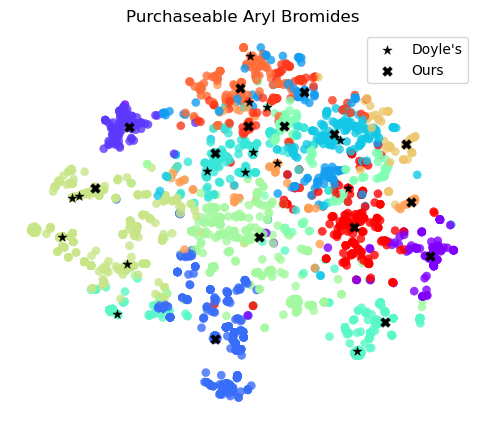

In [29]:
fig, ax = plt.subplots(figsize=(6, 5))

c_list_temp = data_buyable.cluster.to_list()
title = 'Purchaseable Aryl Bromides'

sns.scatterplot(x='tsne1', y='tsne2', data=dfs['tsne2'], s=35, alpha=0.8, linewidth=0.25, c=c_list_temp, cmap='rainbow', edgecolor='face', ax=ax).set_title(title)
ax.scatter(x=dfs['tsne2']['tsne1'][data_buyable['in_doyle'] == True], y=dfs['tsne2']['tsne2'][data_buyable['in_doyle'] == True], s=50, alpha=1.0, linewidth=0.25, marker='*', c='black', edgecolor='face', label='Doyle\'s')
ax.scatter(x=dfs['tsne2']['tsne1'][data_buyable['picked'] == True], y=dfs['tsne2']['tsne2'][data_buyable['picked'] == True], s=50, alpha=1.0, linewidth=0.25, marker='X', c='black', edgecolor='face', label='Ours')
# Remove axes
plt.axis('off')



# Set background color to transparent
plt.gca().set_facecolor('none')

# norm = plt.Normalize(c_list_temp.min(), c_list_temp.max())
# sm = plt.cm.ScalarMappable(cmap="rainbow", norm=norm)
# sm.set_array([])

# # Remove the legend and add a colorbar
# ax.figure.colorbar(sm)

# ax.set_xlim((-13, 17))
# ax.set_ylim((-15, 15))
plt.legend()
# plt.show()
plt.savefig('tsne_buyable_ArBr.png', dpi=500, bbox_inches='tight', transparent=True)

In [ ]:
smiles_list = [
    'C1=CC(N(=O)=O)=CC=C1Br',
]